导入数据
导入库

In [23]:
# %%
import pandas as pd
import numpy as np

import matplotlib.pylab as plt
import seaborn as sns
# 导入模型
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import SGDOneClassSVM
from sklearn.neighbors import KNeighborsClassifier

# 导入交叉验证和评价指标
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
import traceback

#%%

train_data = pd.read_csv('用户新增预测挑战赛公开数据/train.csv')
test_data = pd.read_csv('用户新增预测挑战赛公开数据/test.csv')

In [24]:
# %%
# 文本特征提取函数
def udmap_onethot(d):
    v = np.zeros(9)
    if d == 'unknown':
        return v
    d = eval(d)
    for i in range(1, 10):
        if 'key' + str(i) in d:
            v[i-1] = d['key' + str(i)]       
    return v
def gen_udmap(d):
    if d == 'unknown':
        return 'unknown'
    d = eval(d)
    v = ''
    for i in range(1, 10):
        if 'key' + str(i) in d:
            v = v + 'key' + str(i)
    return v

In [25]:
# 转换为毫秒
train_data['common_ts'] = pd.to_datetime(train_data['common_ts'], unit='ms')
test_data['common_ts'] = pd.to_datetime(test_data['common_ts'], unit='ms')



train_udmap_df = pd.DataFrame(np.vstack(train_data['udmap'].apply(udmap_onethot)))
test_udmap_df = pd.DataFrame(np.vstack(test_data['udmap'].apply(udmap_onethot)))
train_data['udmap_key'] = pd.DataFrame(np.vstack(train_data['udmap'].apply(gen_udmap)))
test_data['udmap_key'] = pd.DataFrame(np.vstack(test_data['udmap'].apply(gen_udmap)))

train_udmap_df.columns = ['key' + str(i) for i in range(1, 10)]
test_udmap_df.columns = ['key' + str(i) for i in range(1, 10)]

train_data = pd.concat([train_data, train_udmap_df], axis=1)
test_data = pd.concat([test_data, test_udmap_df], axis=1)

#%%
train_data['udmap_key'] = pd.factorize(train_data['udmap_key'])[0].astype(np.uint16)
test_data['udmap_key'] = pd.factorize(test_data['udmap_key'])[0].astype(np.uint16)
#%%
# print(train_data['udmap_key'].value_counts())
# %%
# 特征生成
train_data['eid_freq'] = train_data['eid'].map(train_data['eid'].value_counts())
test_data['eid_freq'] = test_data['eid'].map(train_data['eid'].value_counts())

train_data['eid_mean'] = train_data['eid'].map(train_data.groupby('eid')['target'].mean())
test_data['eid_mean'] = test_data['eid'].map(train_data.groupby('eid')['target'].mean())

train_data['udmap_isunknown'] = (train_data['udmap'] == 'unknown').astype(int)
test_data['udmap_isunknown'] = (test_data['udmap'] == 'unknown').astype(int)

train_data['common_ts_day'] = train_data['common_ts'].dt.day
test_data['common_ts_day'] = test_data['common_ts'].dt.day
train_data['common_ts_hour'] = train_data['common_ts'].dt.hour
test_data['common_ts_hour'] = test_data['common_ts'].dt.hour
train_data['common_ts_min'] = train_data['common_ts'].dt.minute
test_data['common_ts_min'] = test_data['common_ts'].dt.minute


one-hot:

In [26]:
# one_hot_col = test_data.columns.tolist()
# print(one_hot_col)
# one_hot_col = ['x1', 'x2', 
#                 'x6', 'x7', 'udmap_key']
# train_data_one_hot = pd.get_dummies(train_data, columns = one_hot_col)
# # print(train_data_one_hot.columns)
# test_data_one_hot = pd.get_dummies(test_data, columns = one_hot_col)

# y_train = train_data['target']


In [27]:
clf_dc = DecisionTreeClassifier()
train_data_ori = train_data.copy(deep=True)
train_data_new = pd.DataFrame()  
test_data_new = pd.DataFrame()
from betatarget import BetaEncoder


N_min = 1000
feature_cols = []  
for c in ['x1', 'x2', 'x4', 'x5', 'x6',
       'x7']:
    # drop 7 8 9 

    # fit encoder
    be = BetaEncoder(c)
    be.fit(train_data, 'target')

    # mean
    feature_name = f'{c}_mean'
    train_data_new[feature_name] = be.transform(train_data, 'mean', 1)
    test_data_new[feature_name]  = be.transform(test_data,  'mean', 1)
    feature_cols.append(feature_name)


    # # mode
    # feature_name = f'{c}_mode'
    # train_data_new[feature_name] = be.transform(train_data, 'mode', N_min)
    # test_data_new[feature_name]  = be.transform(test_data,  'mode', N_min)
    # feature_cols.append(feature_name)
    # # median
    # feature_name = f'{c}_median'
    # train_data_new[feature_name] = be.transform(train_data, 'median', N_min)
    # test_data_new[feature_name]  = be.transform(test_data,  'median', N_min)
    # feature_cols.append(feature_name) 

    # var
    feature_name = f'{c}_var'
    train_data_new[feature_name] = be.transform(train_data, 'var', 1)
    test_data_new[feature_name]  = be.transform(test_data,  'var', 1)
    feature_cols.append(feature_name)     
    
    
    
    # # skewness
    # feature_name = f'{c}_skewness'
    # train_data_new[feature_name] = be.transform(train_data, 'skewness', N_min)
    # test_data_new[feature_name]  = be.transform(test_data,  'skewness', N_min)
    # feature_cols.append(feature_name)
    
    # # kurtosis
    # feature_name = f'{c}_kurtosis'
    # train_data_new[feature_name] = be.transform(train_data, 'kurtosis', N_min)
    # test_data_new[feature_name]  = be.transform(test_data,  'kurtosis', N_min)
    # feature_cols.append(feature_name)  
    
    
train_data_new.fillna(0, inplace=True)
test_data_new.fillna(0, inplace=True)
train_data_new.replace(np.inf, 0, inplace=True)
test_data_new.replace(np.inf, 0, inplace=True)



In [28]:
train_data_key = pd.DataFrame()
test_data_key = pd.DataFrame()
for c in ['key1', 'key2', 'key3', 'key4', 'key5', 'key6', 'key7', 'key8', 'key9' ]:
    train_data_key['eid_'+ c] = train_data['eid'] * train_data[c]
    test_data_key['eid_'+ c] = test_data['eid'] * test_data[c]
# train_data_key.fillna(0, inplace=True)
# test_data_key.fillna(0, inplace=True)
# train_data_key.replace(np.inf, 0, inplace=True)
# test_data_key.replace(np.inf, 0, inplace=True)
# print(train_data_key.head(10))

In [29]:
train_data_cross = pd.DataFrame()
test_data_cross = pd.DataFrame()
for i in ['x1', 'x2', 'x4', 'x5', 'x6',
       'x7', 'eid' ]:
    train_data_cross[i+ '_cnt'] = train_data[i].map(train_data[i].value_counts())
    test_data_cross[i+ '_cnt'] = test_data[i].map(test_data[i].value_counts())
    train_data_cross[i+ '_ratio'] = train_data_cross[i+ '_cnt'] / train_data.shape[0]
    test_data_cross[i+ '_ratio'] = test_data_cross[i+ '_cnt'] / test_data.shape[0]
train_data_cross.fillna(0, inplace=True)
test_data_cross.fillna(0, inplace=True)
train_data_cross.replace(np.inf, 0, inplace=True)
test_data_cross.replace(np.inf, 0, inplace=True)
#%%
cross_list = ['x1', 'x2', 'x4', 'x5', 'x6',
       'x7', 'eid' ]
for i_1 in range(len(cross_list)):
    i = cross_list[i_1]
    for j_1 in range(i_1+1, len(cross_list)):
        j = cross_list[j_1]
        if i == j :
            continue
        if j == 'eid':
            train_data_cross[i+ '_' + j + '_cnt'] = train_data_cross[i+ '_cnt'] * train_data_cross[j+ '_cnt']/ train_data.shape[0]
            test_data_cross[i+ '_' + j + '_cnt'] = test_data_cross[i+ '_cnt'] * test_data_cross[j+ '_cnt']/ test_data.shape[0]
        train_data_cross[i+ '_' + j + '_ratio'] = train_data_cross[i+ '_ratio'] * train_data_cross[j+ '_ratio']
        test_data_cross[i+ '_' + j + '_ratio'] = test_data_cross[i+ '_ratio'] * test_data_cross[j+ '_ratio']
        # train_data_cross[i+ '_' + j + '_cnt'] = train_data_cross[i+ '_cnt'] * train_data_cross[j+ '_cnt']/ train_data.shape[0]
        # train_data_cross[i+ '_' + j + '_cnt'] = test_data_cross[i+ '_cnt'] * test_data_cross[j+ '_cnt']/ test_data.shape[0]

train_data_cross.fillna(0, inplace=True)
test_data_cross.fillna(0, inplace=True)
train_data_cross.replace(np.inf, 0, inplace=True)
test_data_cross.replace(np.inf, 0, inplace=True)
print(train_data_cross.columns)

Index(['x1_cnt', 'x1_ratio', 'x2_cnt', 'x2_ratio', 'x4_cnt', 'x4_ratio',
       'x5_cnt', 'x5_ratio', 'x6_cnt', 'x6_ratio', 'x7_cnt', 'x7_ratio',
       'eid_cnt', 'eid_ratio', 'x1_x2_ratio', 'x1_x4_ratio', 'x1_x5_ratio',
       'x1_x6_ratio', 'x1_x7_ratio', 'x1_eid_cnt', 'x1_eid_ratio',
       'x2_x4_ratio', 'x2_x5_ratio', 'x2_x6_ratio', 'x2_x7_ratio',
       'x2_eid_cnt', 'x2_eid_ratio', 'x4_x5_ratio', 'x4_x6_ratio',
       'x4_x7_ratio', 'x4_eid_cnt', 'x4_eid_ratio', 'x5_x6_ratio',
       'x5_x7_ratio', 'x5_eid_cnt', 'x5_eid_ratio', 'x6_x7_ratio',
       'x6_eid_cnt', 'x6_eid_ratio', 'x7_eid_cnt', 'x7_eid_ratio'],
      dtype='object')


数据分桶

In [30]:
train_data_split = train_data.copy(deep=True)
# print(train_data_split['key3'].value_counts())
train_data_split.loc[train_data_split['key3'].between(0, 52841.0, 'right'), 'key3'] = 1.0
train_data_split.loc[train_data_split['key3'].between(52841.0, 67804.0, 'right'), 'key3'] = 2.0
train_data_split.loc[train_data_split['key3'] > 67804.0, 'key3'] = 3.0
# print(train_data.info)
# print(train_data_split['key3'].value_counts())
#%%
train_data_split['key1'] = pd.cut(train_data_split['key1'], 3, labels=[0.0, 1.0, 2.0])
train_data_split.loc[train_data_split['key2'].between(0, 484.0, 'right'), 'key2'] = 1.0
train_data_split.loc[train_data_split['key2'].between(484.0, 10000.0, 'right'), 'key2'] = 2.0
# train_data_split.loc[train_data_split['key6']  != 0.0, 'key6'] = 1.0
train_data_split = train_data_split[['key1', 'key2', 'key3']]


test_data_split = test_data.copy(deep=True)

test_data_split.loc[test_data_split['key3'].between(0, 52841.0, 'right'), 'key3'] = 1.0
test_data_split.loc[test_data_split['key3'].between(52841.0, 67804.0, 'right'), 'key3'] = 2.0
test_data_split.loc[test_data_split['key3'] > 67804.0, 'key3'] = 3.0
# print(train_data.info)

test_data_split['key1'] = pd.cut(test_data_split['key1'], 3, labels=[0.0, 1.0, 2.0])
test_data_split.loc[test_data_split['key2'].between(0, 484.0, 'right'), 'key2'] = 1.0
test_data_split.loc[test_data_split['key2'].between(484.0, 10000.0, 'right'), 'key2'] = 2.0
# test_data_split.loc[test_data_split['key6']  != 0.0, 'key6'] = 1.0

test_data_split = test_data_split[['key1', 'key2', 'key3']]

In [31]:
y_train = train_data['target']
# try:
#     train_data.drop(['udmap', 'common_ts', 'uuid', 'target'], axis=1, inplace=True)    
# except:
#     print(traceback.format_exc())
# # train_data.info()
# # train_total = train_data_new.merge(train_data_new,how='left')
# train_data_new['target'] = y_train

In [32]:

# print(train_data_one_hot.info())
#%%
# # Train the DTree
# temp_df = pd.concat([train_data_one_hot.drop(['key1', 'key2', 'key3', 'key6', 'udmap', 'common_ts', 'uuid', 'target', 'udmap_key_11'], axis=1), 
#                     train_data_split,
#                      train_data_new.drop(['target'], axis = 1)], axis=1)
# # print(temp_df.info())
# # temp_df.fillna(0, inplace=True)
# # temp_df.replace(np.inf, 0, inplace=True)
# # train_data_cross.fillna(0, inplace=True)
# # for i in 
# score = cross_val_score(clf_dc,
#                         pd.concat([temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9'],axis=1), train_data_cross], axis=1),
#                         y_train,
#                         cv=5,
#                         scoring='f1')
# print('the f1 score for decision tree ')
# print(score, score.mean())

上面的上传只有0.61.。。。。。。。

In [33]:
one_hot_col = ['x1', 'x2', 
                'x6', 'x7', 'udmap_key']
key_hot = ['key1', 'key2', 'key3']

train_data_split_oh = pd.get_dummies(train_data_split, columns = key_hot)
test_data_split_oh = pd.get_dummies(test_data_split, columns= key_hot)

train_data_one_hot = pd.get_dummies(train_data, columns = one_hot_col)
# print(train_data_one_hot.columns)
test_data_one_hot = pd.get_dummies(test_data, columns = one_hot_col)


temp_df = pd.concat([train_data_one_hot.drop(['key1', 'key2', 'key6', 'udmap', 'common_ts', 'uuid', 'target', 'udmap_key_11'], axis=1),
                     train_data_split_oh, 
                                       
                train_data_cross[['x1_x4_ratio', 'x1_x5_ratio',
                                        'x2_x4_ratio', 'x2_x5_ratio',
                                        'x4_x7_ratio', 'x5_x7_ratio']],
                train_data_new], axis=1)

# for i in train_data_cross.columns:
# # for i in 
#     score = cross_val_score(clf_dc,
#                         pd.concat([temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9'],axis=1), train_data_cross[i]], axis=1),
#                         y_train,
#                         cv=5,
#                         scoring='f1')
#     print('the f1 score for decision tree with appending ' + i + ' :')
#     print(score, score.mean())

# try:

#         score = cross_val_score(clf_dc,
#                         pd.concat([temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9', 'x5_mean', 'x7_mean', 'eid_freq', 'key3'],axis=1), 
#                                 train_data_key[['eid_key4', 'eid_key7', 'eid_key8']]], axis=1),
#                         y_train,
#                         cv=5,
#                         scoring='f1')
#         print('the f1 score for decision tree with appending  :')
#         print(score, score.mean())
# except:
#         print(traceback.format_exc())


In [34]:
fit_train = pd.concat([temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9', 'x5_mean', 'x7_mean', 'eid_freq', 'key3', 'key4', 'key5'],axis=1), 
                                train_data_key[['eid_key4', 'eid_key7', 'eid_key8']]], axis=1)

score = cross_val_score(clf_dc,
                        fit_train,
                        y_train,
                        cv=5,
                        scoring='f1')
print('the f1 score for decision tree with appending  :')
print(score, score.mean())

clf_dc.fit(fit_train, 
           y_train)

the f1 score for decision tree with appending  :
[0.75263795 0.75624471 0.74997893 0.75183678 0.75108043] 0.7523557597922746


DecisionTreeClassifier()

common_ts_min 0.1459169733804719
common_ts_hour 0.14041126029306755
common_ts_day 0.09664741616390066
eid_mean 0.08587266634776419
x2_x5_ratio 0.05625889333186615
x1_x5_ratio 0.045907480016249565
x2_x4_ratio 0.04268767173513441
x7_mean 0.04128708513382167
x5_mean 0.04038304635843155
x5 0.03475875073296681
x1_x4_ratio 0.03206311408392546
x5_x7_ratio 0.029818352480747275
x4_x7_ratio 0.02066382510414848
x4 0.019268923826641554
x4_mean 0.016188968189278747
x5_var 0.015154762819347196
x2_mean 0.010878594471434463
x2_1 0.009983573421553354
udmap_key_2 0.008972174738944412
x4_var 0.008195165935183702
x2_3 0.008006250987540967
key3 0.007329151876816275
x1_0 0.006231819447511758
x1_mean 0.005838833341238789
eid_freq 0.0057612216488683796
x7_var 0.005387630396453765
key2 0.004633123086472689
x6_mean 0.004444907127828387
x2_var 0.004350733150263349
x7_0 0.0039295409972318835
0.9572319106251053


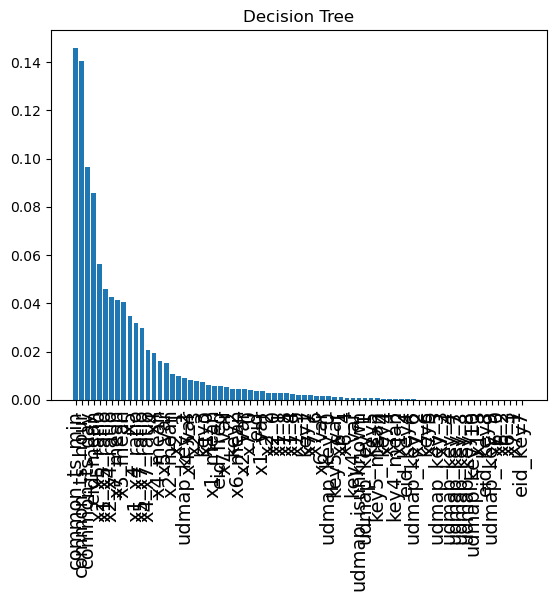

In [97]:
# clf_dc.fit(pd.concat([temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9'],axis=1), 
#                                 train_data_key[['eid_key4', 'eid_key7', 'eid_key8']]], axis=1), 
#            y_train)


# importances_dc = clf_dc.feature_importances_
# # train_data_dc = temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9'],axis=1)
# train_data_imp = pd.concat([temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9'],axis=1), 
#                                 train_data_key[['eid_key4', 'eid_key7', 'eid_key8']]], axis=1)
# # indices = np.argsort(importances_dc)[::-1] #reverse
# index_sorted = np.flipud(np.argsort(importances_dc))
# names = train_data_imp.columns
# plt.figure()
# plt.bar(names[index_sorted],importances_dc[index_sorted])
# plt.xticks(rotation=90, fontsize=14)
# plt.title('Decision Tree')
# sum = 0
# slec_list = []
# for i in range(0, 30):
#     print(names[index_sorted[i]], importances_dc[index_sorted[i]])
#     sum = sum + importances_dc[index_sorted[i]]
#     slec_list.append(names[index_sorted[i]])
# print(sum)

In [ ]:

# train_data_imp.drop(['x5_mean', 'x7_mean'])
# print(slec_list)
# for c in slec_list:
    

#     score = cross_val_score(clf_dc,
#                     train_data_imp.drop(c, axis=1),
#                     y_train,
#                     cv=5,
#                     scoring='f1')
#     print('the f1 score for decision tree dropping ' + c + ':')
#     print(score, score.mean())

In [36]:
from sklearn.model_selection import RandomizedSearchCV
clf_rf = RandomForestClassifier()
clf_GB = GradientBoostingClassifier()

n_estimators = [int(x) for x in np.linspace(start = 100, stop = 3000, num = 15)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10, 15]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               }
random_grid_forRF = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap':bootstrap
               }


# score = cross_val_score(clf_rf,
#                         fit_train,
#                         y_train,
#                         cv=5,
#                         scoring='f1')
# print('the f1 score for RF with appending  :')
# print(score, score.mean())
clfrf_opt = RandomizedSearchCV(estimator=clf_rf, param_distributions=random_grid_forRF, n_iter=30, cv=5, n_jobs = -1)
clfrf_opt.fit(fit_train, y_train)



In [ ]:
score = cross_val_score(clfrf_opt,
                        fit_train,
                        y_train,
                        cv=5,
                        scoring='f1')
print('the f1 score for RF opt with appending  :')
print(score, score.mean())

In [ ]:
# importances_dc = clf_dc.feature_importances_
# # train_data_dc = temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9'],axis=1)
# train_data_dc = pd.concat([temp_df.drop([ 'x3', 'x8', 'key7', 'key8', 'key9'],axis=1), 
#                            train_data_cross[['x1_x2_ratio', 'x1_x4_ratio', 'x1_x5_ratio', 'x1_x7_ratio', 
#                                              'x2_x4_ratio', 'x2_x5_ratio', 'x2_x6_ratio', 'x2_x7_ratio',
#                                              'x4_x7_ratio', 'x5_x7_ratio']]], axis=1)
# # indices = np.argsort(importances_dc)[::-1] #reverse
# index_sorted = np.flipud(np.argsort(importances_dc))
# names = train_data_dc.columns
# plt.figure()
# plt.bar(names[index_sorted],importances_dc[index_sorted])
# plt.xticks(rotation=90, fontsize=14)
# plt.title('Decision Tree')
# for i in range(0, 30):
#     print(names[index_sorted[i]], importances_dc[index_sorted[i]])

In [35]:
test_data_temp = pd.concat([test_data_one_hot.drop(['key1', 'key2', 'key3', 'key6', 'udmap', 'common_ts', 'uuid'], axis=1), 
                            test_data_split_oh,
                            test_data_new,
                            test_data_cross[['x1_x4_ratio', 'x1_x5_ratio',
                                        'x2_x4_ratio', 'x2_x5_ratio',
                                        'x4_x7_ratio', 'x5_x7_ratio']],
                                            test_data_key[['eid_key4', 'eid_key7', 'eid_key8']]]
                            , axis=1)
test_data_temp = test_data_temp.drop([ 'x3', 'x8', 'key7', 'key8', 'key9', 'x5_mean', 'x7_mean', 'eid_freq', 'key4', 'key5'], axis=1)
test_data_temp = test_data_temp[fit_train.columns]
    
pd.DataFrame({
    'uuid': test_data['uuid'],
    'target': clf_dc.predict(test_data_temp)
}).to_csv('14.csv', index=None)
